# Sentiment Analysis

Computationally identifying and categorizing the expressed opinion in the text in order to the determine the attitude of the user opinion i.e. _positive_, _negative_ or _neutral_ .

The common use of this topic is to determine about how the general population feel about this topic. It aims to determine the attitude of a speaker, writer, or other subject with respect to some topic or the overall contextual polarity or emotional reaction to a document, interaction, or event. 

Sentimment analysis is known by other names:

1. Opinion extraction 

2. Opinion mining

3. Sentiment mining

4. Subjectivity analysis

--------

## Baseline Algorithm
1.  Tokenization
2.  Feature Extraction
3.  Classification using different classifiers
    - Naive Bayes 
    - SVM
    - Logistic Regression
    - Random Forest
    - Decision Tree
    - Linear SVC (SVM)

In [361]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from bs4 import BeautifulSoup
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.cross_validation import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srossgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [285]:
# Import data
df = pd.read_csv("/Users/srossgupta/Desktop/PDS/Tutorial/Data/finalizedfull.csv", encoding='utf-8' )
#Drop the NA columns
df.dropna(axis=0, how="any", inplace=True)
df.head()

,tweet,senti
0,@united UA5396 can wait for me. I'm on the gro...,0.0
1,I hate Time Warner! Soooo wish I had Vios. Can...,0.0
2,"@united Oh, we are sure it's not planned, but ...",0.0
3,Tom Shanahan's latest column on SDSU and its N...,2.0
4,Found the self driving car!! /IWo3QSvdu2,2.0


In [286]:
#Data distribution around the code
print(df["senti"].value_counts())
len(df)

4.0    381
0.0    377
2.0    239
Name: senti, dtype: int64


997

## Data Cleaning
- Extracting information from HTML
- Removing @ (Tweet name)
- Removing url links
- Removing Byte order mark
- Removing Hashtags/ Numbers
- Converting the text to lowercase

### Extracting information from HTML
Decoding HTML to extract the general text out of the data. Use Beautiful soup for this.<br />

### Removing @ (Twitter username)
We are removing the twitter username from the data. Though it does contain certain information but information contained is not substantial to have an impact on the sentiment analysis.<br />
### Removing url links
Eliminate all urls using regex matching. Information contained in the urls is very little to be be considered in sentiment analysis<br />
### Removing Byte order mark
Twitter data contains strange Byte order marks in their data. This is removed using the regex<br />
### Removing Hashtags/ Numbers
Hashtags contains an important informating conveying the sentiment of the author so it is important to include the tags into our analysis. Thereby I replace all the `#` by blanks. <br /> Similarly I also decided to exclude numbers from the sentiment analysis model using the regex because they dont add any value to the analysis
<br />
### Convert the text to lowercase
Convert the whole text to lowercase to get into consistency
<br />
### Handling the  Negatives
- Handle the negatives i.e. isn't -- is not, can't -- can not
- It is important because word `not` has special weightage in classifying the tweet as the negative word

In [287]:
def datacleaning(df):
    #HTML decoding, extracting the text from HTML
    df["tweet"]= df.apply(lambda row: BeautifulSoup(row["tweet"], 'lxml').get_text(), axis=1)
    #removing @
    df["tweet"]= df.apply(lambda row: re.sub(r'@[\w0-9]+','',row["tweet"],re.IGNORECASE), axis=1)
    #removing URL tags
    df["tweet"]= df.apply(lambda row: re.sub(r'https?://[\w0-9./]+','',row["tweet"],re.IGNORECASE), axis=1)
    df["tweet"]= df.apply(lambda row: re.sub(r'www.[^ ]+','',row["tweet"],re.IGNORECASE), axis=1)
    
    #removing Byte order marks
    df["tweet"]= df.apply(lambda row: row["tweet"].replace(u"\ufffd", "?"), axis=1)
    #Convert the data to lowercase
    df["tweet"]= df.apply(lambda row: row["tweet"].lower(), axis=1)    
    #removing hashtag/numbers and punctuations
    df["tweet"]= df.apply(lambda row: re.sub(r"[^a-zA-Z ]+",'',row["tweet"]), axis=1)
    return df



In [288]:
def handling_negatives(text):
#handling the negatives
    # Refernce https://github.com/tthustla/twitter_sentiment_analysis_part2/blob/master/Capstone_part3-Copy1.ipynb
    negatives = {"isn't":"is not", "aren't":"are not","won't":"will not", "wasn't":"was not",\
                "haven't":"have not","shouldn't":"should not","hasn't":"has not","hadn't":"had not",\
                "wouldn't":"would not",  "didn't":"did not", "weren't":"were not",\
                "can't":"can not","couldn't":"could not","don't":"do not","mightn't":"might not",\
                "mustn't":"must not","doesn't":"does not","isnt":"is not", "arent":"are not","wont":"will not", "wasnt":"was not",\
                "havent":"have not","shouldnt":"should not","hasnt":"has not","hadnt":"had not",\
                "wouldnt":"would not",  "didnt":"did not", "werent":"were not",\
                "cant":"can not","couldnt":"could not","dont":"do not","mightnt":"might not",\
                "mustnt":"must not","doesnt":"does not"}
    negative_pattern = re.compile(r'\b(' + '|'.join(negatives.keys()) + r')\b')
    negative_sentence = negative_pattern.sub(lambda row: negatives[row.group()], text)
    
    return negative_sentence

In [289]:
clean_df = datacleaning(df)
clean_df["tweet"] = clean_df["tweet"].apply(handling_negatives)
# converting the scores into neutral positive and negative tweet
clean_df["senti"] = clean_df["senti"].map({0:0,2:1,4:1})

In [290]:
clean_df.head()

,tweet,senti
0,ua can wait for me im on the ground trying to...,0
1,i hate time warner soooo wish i had vios can n...,0
2,oh we are sure its not planned but it occurs ...,0
3,tom shanahans latest column on sdsu and its nc...,1
4,found the self driving car iwoqsvdu,1


### Removing the words of length  1(one)
words which are of length "one" is removed from corpus because they dont contribute to build our analysis in our sentiment model

In [291]:
def handle_length(text):
    tokenizer = nltk.tokenize.word_tokenize
    words = tokenizer(text)
    fin=[]
    for word in words:
        if len(word)>1:
            fin.append(word)
    return " ".join(fin)
    
clean_df["tweet"] = clean_df["tweet"].apply(handle_length)

#Saving the clean file
clean_df.to_csv("clean_df.csv",encoding='utf-8')

## Wordcloud
Understand the spread of the words in the existing data. The clouds give weightage of words that appear more frequently in the text thus helping us determine which words are more prominently used to classify the tweets

In [360]:
negative_tweet=[]
positive_tweet=[]
for i in range(len(clean_df)):
    if clean_df["senti"][i]==0:
        negative_tweet.append(clean_df["tweet"][i])
    else:
        positive_tweet.append(clean_df["tweet"][i])
        
negative_tweet_string = " ".join(negative_tweet)
positive_tweet_string = " ".join(positive_tweet)

## Negative Word Cloud
Generating the word cloud for the negative tweets, telling about which words are frequently used for negative tweet in the dataset

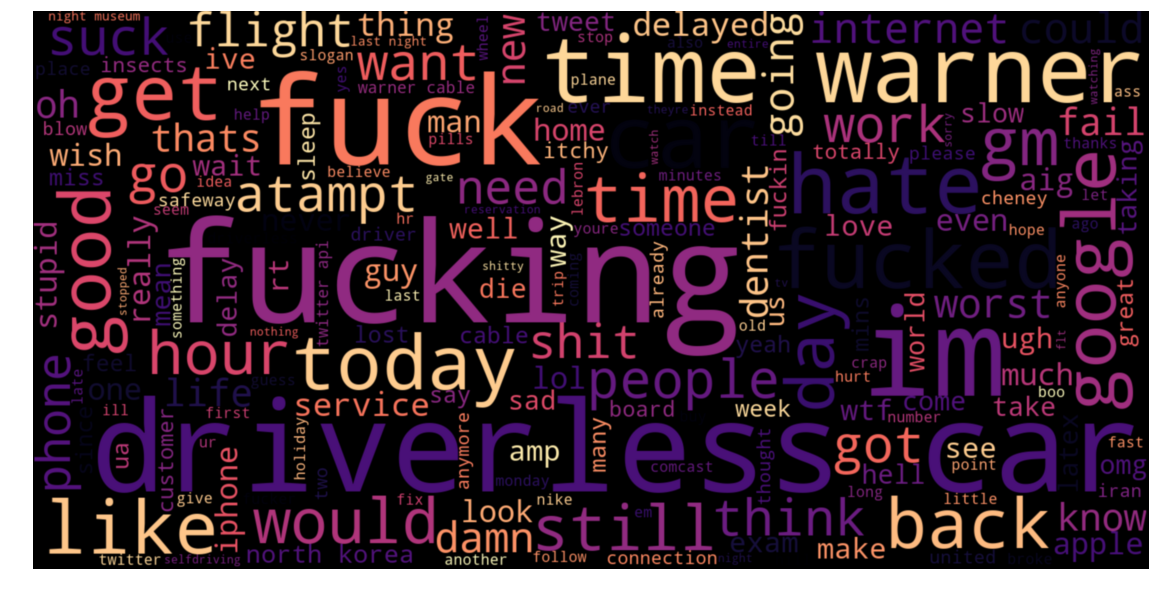

In [294]:
wc = WordCloud(width=1600, height=800,max_font_size=200,stopwords=nltk.corpus.stopwords.words('english')\
                     , colormap="magma").generate(negative_tweet_string)
plt.figure(figsize=(20,18))
plt.imshow(wc, interpolation="bicubic")
plt.axis("off")
plt.show()

## Positive Word Cloud
Generating the word cloud for the positive tweets, telling about which words are frequently used for the positive tweets in the dataset

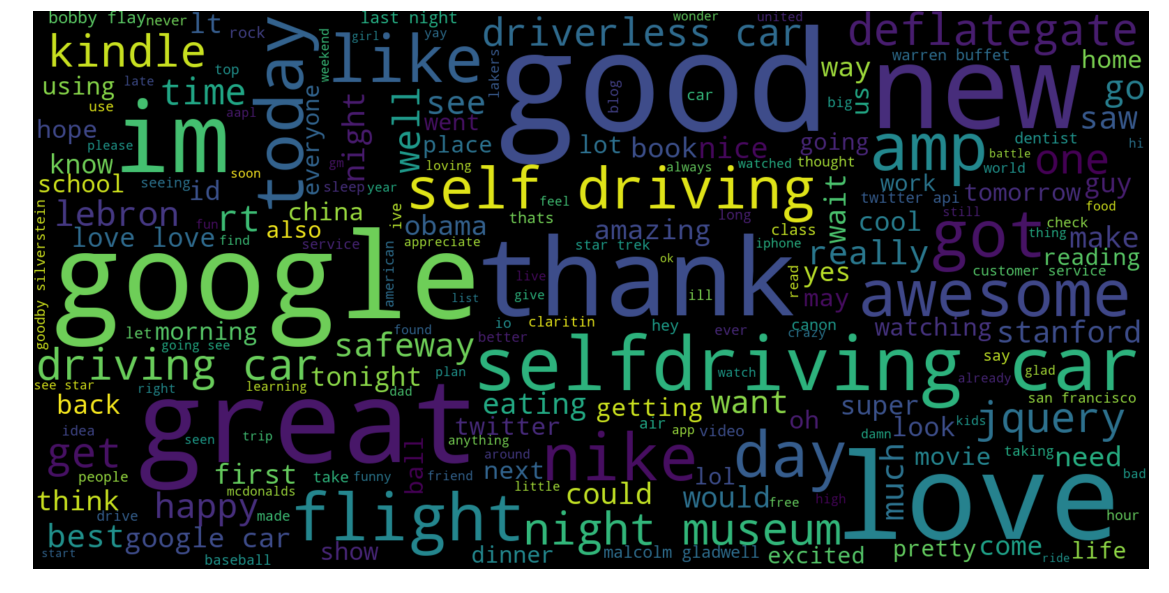

In [295]:
wc = WordCloud(width=1600, height=800,max_font_size=200,stopwords=nltk.corpus.stopwords.words('english')).generate(positive_tweet_string)
plt.figure(figsize=(20,18))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### Feature engineering and Model Fitting:
- Tokenization - Break the sentences into bag of words by splitting across the space
- Create different n-grams to check with different type of models i.e. `unigram,  bigram` 
- Word vectorizer - Create different word vectors using in-built library i.e. count vectorizer, tfidf vectorizer
-  Fitting the different models to evaluate the performance of each

## Train Test Split
Going by the common rule , split the data into 80:20 ratio. 80% of the data is the part of the train data whereas remaining 20% of the data is test data. We have also set the random seed to 23 to get the same train test split every time

In [323]:
x_train, x_test, y_train, y_test = \
            train_test_split(clean_df["tweet"], clean_df["senti"], test_size=.02, random_state=23)

## Selecting between unigram and bigram model
A bigram or digram is a sequence of two adjacent elements from a string of tokenized words. A bigram is an n-gram for n=2. <br />
Whereas unigram is an single tokenized words present in the bag of words i.e. n-gram for n=1
#### Using Countvectorizer
- Converts the bag of text documents to a matrix of token counts

[2]: Breitinger, Corinna; Gipp, Bela; Langer, Stefan (2015-07-26). "Research-paper recommender systems: a literature survey". International Journal on Digital Libraries. 17 (4): 305–338. doi:10.1007/s00799-015-0156-0. ISSN 1432-5012. 

In [359]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import sklearn.feature_extraction as sk 
# vectorizer for unigram
vectorizer1 = sk.text.CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'),\
                                      max_features=10000, ngram_range=(1,1))
# vectorizer for bigram
vectorizer2 = sk.text.CountVectorizer(stop_words=nltk.corpus.stopwords.words('english'), \
                                      max_features=10000, ngram_range=(1,2))
lr = LogisticRegression()
pipeline1 = Pipeline([("vectorizer",vectorizer1),("model",lr)])
pipeline2 = Pipeline([("vectorizer",vectorizer2),("model",lr)])
sentiment = pipeline1.fit(x_train, y_train)
y_pred1 = sentiment.predict(x_test)
accuracy = accuracy_score(y_test, y_pred1)
print("accuracy with unigram:",accuracy)
sentiment = pipeline2.fit(x_train, y_train)
y_pred2 = sentiment.predict(x_test)
accuracy = accuracy_score(y_test, y_pred2)
accuracy = accuracy_score(y_test, y_pred2)
print("accuracy with unigram+bigram:",accuracy)


accuracy with unigram: 0.75
accuracy with unigram+bigram: 0.75


## Using TFIDF (term frequency–inverse document frequency)
- Numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus
- Nowadays, tf-idf is one of the most popular term-weighting schemes; 83% of text-based recommender systems in the domain of digital libraries use tf-idf [2]

[2]: Breitinger, Corinna; Gipp, Bela; Langer, Stefan (2015-07-26). "Research-paper recommender systems: a literature survey". International Journal on Digital Libraries. 17 (4): 305–338. doi:10.1007/s00799-015-0156-0. ISSN 1432-5012. 

In [354]:
# vectorizer for unigram
tfidf1 = sk.text.TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('english'),\
                                       ngram_range=(1,1))
# vectorizer for bigram
tfidf2 = sk.text.TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('english'), \
                                        ngram_range=(1,2))
lr = LogisticRegression()
pipeline1 = Pipeline([("vectorizer",tfidf1),("model",lr)])
pipeline2 = Pipeline([("vectorizer",tfidf2),("model",lr)])
sentiment = pipeline1.fit(x_train, y_train)
y_pred1 = sentiment.predict(x_test)
accuracy = accuracy_score(y_test, y_pred1)
print("accuracy with unigram :",accuracy)
sentiment = pipeline2.fit(x_train, y_train)
y_pred2 = sentiment.predict(x_test)
accuracy = accuracy_score(y_test, y_pred2)
accuracy = accuracy_score(y_test, y_pred2)
print("accuracy with unigram+bigram:",accuracy)

accuracy with unigram : 0.7
accuracy with unigram+bigram: 0.75


### Analysis 
- Based on the analysis above we concluded that the model combining TFIDF vectorizer is better than the count vectorizer as it takes in account the product of document frequency and inverse document frequency thus making better representation of the data in vector form
- We also conclude that model combining both unigram and bigrams tend to produce better performance as the data contains the hidden interaction between the words not present in the unigram model

## Comparison of different models

In [350]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# vectorizer for bigram
tfidf2 = sk.text.TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('english'), \
                                        ngram_range=(1,2))

models = [MultinomialNB(),RandomForestClassifier(), DecisionTreeClassifier(),LinearSVC(), LogisticRegression()]
model_names = ["Multinomial Naive bayes","Random Forest","Decision tree","SVM","Logistic Regression"]

for i in range(len(models)):
    pipeline = Pipeline([("vectorizer",tfidf2),("model",models[i])])
    sentiment = pipeline.fit(x_train, y_train)
    y_pred = sentiment.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy for model",model_names[i],":",accuracy)

Accuracy for model Multinomial Naive bayes : 0.75
Accuracy for model Random Forest : 0.7
Accuracy for model Decision tree : 0.7
Accuracy for model SVM : 0.8
Accuracy for model Logistic Regression : 0.75


<h2> Based on our analysis almost all the model performs have the similar accuracy in the range of 70% - 80%. However SVM performs best giving us the best results in comparison to other models i.e 80%. Having said that there is not a singular approach of implementing a single model while doing sentiment analysis. With the dataset domain change data distribution changes similarly efficiency of the model 

### Next Steps:
1. <b>Word2vec</b><br />
Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space<br />
It is a combination CBOW (continuous bag of words) and skip-grams approach. Both of these models learn weights further represented as word vector representation<br />
2. <b>Dimensionality Reduction</b><br />
 - Chi Square
 - Principal Component Analysis (PCA)<br />
 
3. <b>Neural Network using Keras</b><br /> 



## References:
- https://github.com/tthustla/twitter_sentiment_analysis_part1
- https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
- https://web.stanford.edu/class/cs124/lec/sentiment.pdf
- https://www.kaggle.com/c/sentiment-analysis-on-imdb-movie-reviews
- http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/

### Dataset URL
https://old.datahub.io/dataset/twitter-sentiment-analysis